## Imports

In [10]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


---

## Helper-functions

We're gonna use this function to quickly plot a 2D SimpleITK image with a grayscale colormap and accompanying axes

In [11]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    print type(nda)
    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

---

## Options

In [12]:
# Paths to the .mhd files
filenameT1 = "./patient_109/mr_T1/patient_109_mr_T1.mhd"
filenameT2 = "./patient_109/mr_T2/patient_109_mr_T2.mhd"

# Slice index to visualize with 'sitk_show'
idxSlice = 26

# int label to assign to the segmented gray matter
labelGrayMatter = 1

---

## Image-Data Input

In [13]:
imgT1Original = SimpleITK.ReadImage(filenameT1)
imgT2Original = SimpleITK.ReadImage(filenameT2)

<type 'numpy.ndarray'>


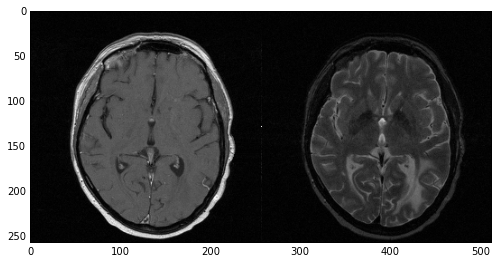

In [14]:
sitk_show(SimpleITK.Tile(imgT1Original[:, :, idxSlice],
                         imgT2Original[:, :, idxSlice],
                         (2, 1, 0)))

In [16]:
type(imgT1Original)

SimpleITK.SimpleITK.Image

---

## Image Smoothing/Denoising

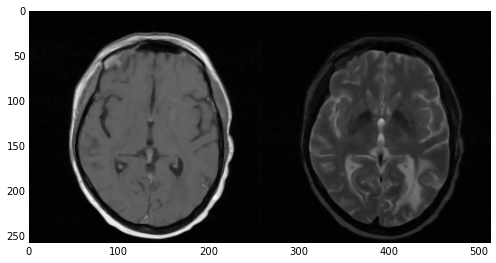

In [7]:
imgT1Smooth = SimpleITK.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgT2Smooth = SimpleITK.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

sitk_show(SimpleITK.Tile(imgT1Smooth[:, :, idxSlice], 
                         imgT2Smooth[:, :, idxSlice], 
                         (2, 1, 0)))

---

## Seed Definition

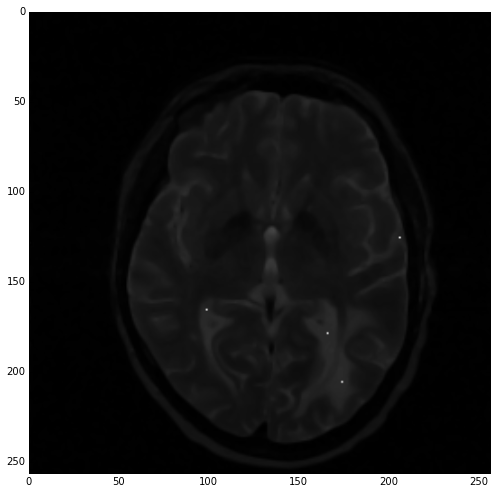

In [27]:
lstSeeds = [(165, 178, idxSlice),
            (98, 165, idxSlice),
            (205, 125, idxSlice),
            (173, 205, idxSlice)]

imgSeeds = SimpleITK.Image(imgT2Smooth)

for s in lstSeeds:
    imgSeeds[s] = 10000

sitk_show(imgSeeds[:, :, idxSlice])

---

## Auxiliary Function: Vector-Image Tiling

We'll use this function to `Tile` multiple multi-component (vectorial) images

In [26]:
def sitk_tile_vec(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(SimpleITK.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(SimpleITK.Tile(lstImgToTile, (len(lstImgs), 1, 0)))
    sitk_show(SimpleITK.Compose(lstImgToCompose))

---

## Uni-Modal Segmentation

Region-growing segmentation on each of the two images based on the predefined seeds

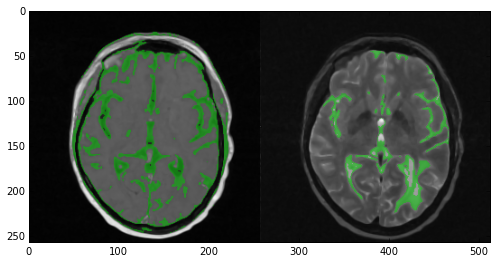

In [20]:
imgGrayMatterT1 = SimpleITK.ConfidenceConnected(image1=imgT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.0,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT2 = SimpleITK.ConfidenceConnected(image1=imgT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=7,
                                                multiplier=1.5,
                                                replaceValue=labelGrayMatter)

imgT1SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
imgT2SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT2Smooth), 
                                imgGrayMatterT2.GetPixelID())

sitk_tile_vec([SimpleITK.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], 
                                      imgGrayMatterT1[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterT2[:,:,idxSlice])])

---

## Multi-Modal Segmentation

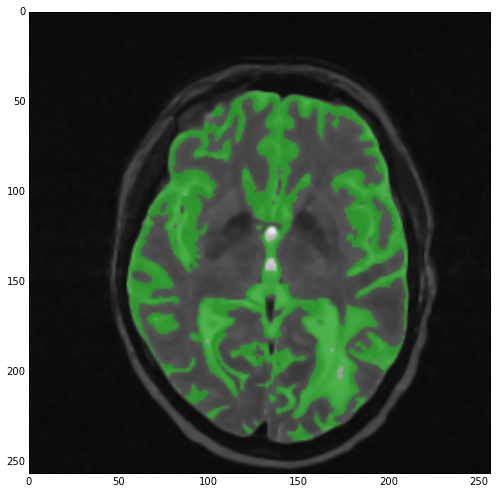

In [23]:
imgComp = SimpleITK.Compose(imgT1Smooth, imgT2Smooth)

imgGrayMatterComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                 imgGrayMatterComp[:,:,idxSlice]))

## MHD Output

In [29]:
SimpleITK.WriteImage(imgGrayMatterComp, "GrayMatter.mhd")